```{index} single: Pyomo; kernel library
```
```{index} single: quadratic optimization
```
```{index} single: application; support vector machines
```
```{index} single: application; binary classification
```
```{index} single: application; counterfeit banknotes
```
# Support Vector Machines for Binary Classification

Support Vector Machines (SVM) are a type of supervised machine learning model. Similar to other machine learning techniques, training an SVM classifier involves solving an optimization problem. Such a problem is solved once using training samples with known outcomes and the optimal solution describes the best parameters for the classifier. The resulting classifier can then be applied to classify data with unknown outcomes.

In this notebook, we demonstrate the process of creating an SVM for binary classification using both linear and quadratic optimization. Our implementation will initially focus on linear support vector machines, which separate the feature space by means of a hyperplane. We will explore both primal and dual formulations. Then, using kernels, the dual formulation is extended to binary classification in higher-order and nonlinear feature spaces.

In [1]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_mosek()

pyomo was previously installed
Consult docs.mosek.com for installation procedures ... installation failed.


False

## Binary Classification

Binary classifiers are functions designed to answer questions such as "Does this medical test indicate disease?", "Will this specific customer enjoy that specific movie?", "Does this photo include a car?", or "Is this banknote genuine or counterfeit?" These questions are answered based on the values of "features", which may include physical measurements or other types of data collected from a representative sample with known outcomes.

For example, consider a device installed in a vending machine to detect banknotes. The classifier's goal is to accurately identify and accept genuine banknotes while rejecting counterfeit ones. The classifier's performance can be assessed using definitions in the following table, where "positive" refers to an instance of a genuine banknote.

<center>

| | Predicted Positive  | Predicted Negative | 
| :-- | :--: | :--: | 
| Actual Positive | True Positive (TP) | False Negative (FN) |
| Actual Negative | False Positive (FP) | True Negative (TN) |

</center>

A vending machine user would be frustrated if a genuine banknote is incorrectly rejected as a false negative. **Sensitivity** is defined as the number of true positives (TP) divided by the total number of actual positives (TP + FN). A high sensitivity means almost all genuine banknotes are accepted making it the preferred outcome for users.

The vending machine owner, on the other hand, wants the machine to avoid accepting counterfeit banknotes and would therefore prefer a low number of false positives (FP). **Precision** is the number of true positives (TP) divided by the total number of predicted positives (TP + FP). A high precision implies almost all of the accepted notes are genuine, making it the preferred outcome for the owner.

* **Sensitivity**: The number of true positives divided by the total number of actual positives. High sensitivity indicates a low false negative rate.

* **Precision**: The number of true positives identified by the model divided by the total number of predicted positives, which includes both true and false positives. High precision indicates a low false positive rate.

To achieve high sensitivity, a classifier can follow the "innocent until proven guilty" standard, rejecting banknotes only when certain they are counterfeit. To achieve high precision, a classifier can adopt the "guilty unless proven innocent" standard, rejecting banknotes unless absolutely certain they are genuine. The challenge in developing binary classifiers is to balance these conflicting objectives and optimize performance from both perspectives simultaneously. In this notebook, we will see how various SVMs perform in striking this balance.

## The Data Set 

Our goal is to train a binary classifier to detect counterfeit banknotes. We consider a [public data set](https://archive.ics.uci.edu/ml/datasets/banknote+authentication) containing data from a collection of known genuine and known counterfeit banknote specimens. The data includes four continuous statistical measures obtained from the wavelet transform of banknote images named variance, skewness, kurtosis, and entropy, and a binary variable named class which is 0 if genuine and 1 if counterfeit.

### Read data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pyomo.environ as pyo

# read data set
df = pd.read_csv("../../datasets/data_banknote_authentication.txt", header=None)
df.columns = ["variance", "skewness", "curtosis", "entropy", "class"]
df.name = "Banknotes"

# show a few rows
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [3]:
# get a statistical description of the data set
df.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


### Select features and training sets

Following customary practices, we divide the data set into a **training set** used to train the classifier, and a **testing set** that will be used to evaluate the performance of the classifier. To enable plotting of the results for visualization purposes, we select a two-dimensional subset of the features: variance and skewness.

The SVMs are traditionally explained in a setting where the label of one class is $-1$ and of the other is $+1$, therefore we rescale the "class" feature to have values of $+1$ for genuine banknotes and $-1$ for counterfeit banknotes. 

In [4]:
# create training and validation test sets
df_train, df_test = train_test_split(df, test_size=0.2)

# select training features
features = ["variance", "skewness"]

# separate into features and outputs
X_train = df_train[features]
y_train = 1 - 2 * df_train["class"]

# separate into features and outputs
X_test = df_test[features]
y_test = 1 - 2 * df_test["class"]

The following cell presents a simple function to create a scatter plot for a labeled 2D set of features. The function assigns default labels and colors, and passes along other keyword arguments.

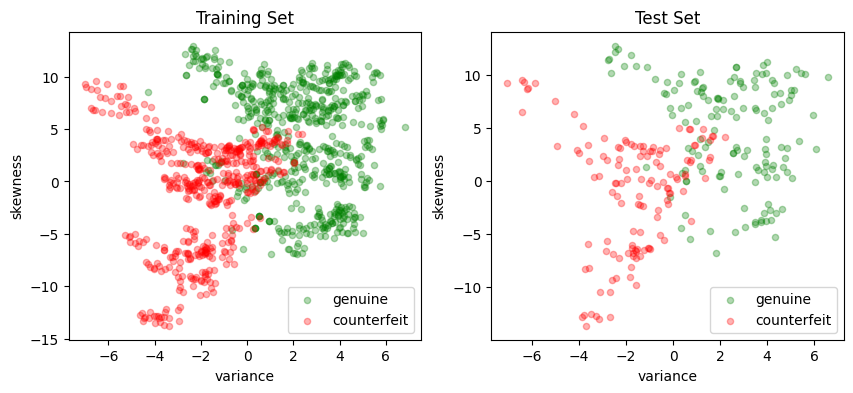

In [5]:
# scatter plot function for labeled dtata with default labels and colors
def scatter(X, y, labels=["+1", "-1"], colors=["g", "r"], **kwargs):
    # prepend common keyword arguments for all scatter plots
    kw = {"x": 0, "y": 1, "kind": "scatter", "alpha": 0.3} | kwargs

    # ignore useless warnings from matplotlib scatter plot
    import warnings

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        kw["ax"] = X[y > 0].plot(**kw, c=colors[0], label=labels[0])
        X[y < 0].plot(**kw, c=colors[1], label=labels[1])


# plot training and test sets
labels = ["genuine", "counterfeit"]
colors = colors = ["g", "r"]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
scatter(X_train, y_train, labels, colors, ax=ax[0], title="Training Set")
scatter(X_test, y_test, labels, ax=ax[1], title="Test Set")
plt.show()

## Support vector machines (SVM)

### Linear SVM classifier

A linear support vector machine (SVM) is a binary classification method that uses a linear equation to determine the class assignment. The basic formula is expressed as:

$$y^{pred} = \text{sgn}\ ( w^\top x + b)$$

where $x\in\mathbb{R}^p$ is a point in the feature space and $\text{sgn}$ is a function defined as

$$
\text{sgn}(x) =
\begin{cases}
-1 & x < 0 \\
0 & x = 0 \\
1 & x > 0.
\end{cases}
$$

Here $w\in \mathbb{R}^p$ represents a set of coefficients, $w^\top x$ is the dot product, and $b$ is a scalar coefficient. The linear function divides the feature space using the hyperplane defined by $w$ and $b$. Points on one side of the hyperplane are assigned a positive outcome (+1), while points on the other side are assigned a negative outcome (-1).

The following code cell contains a Python implementation of a linear SVM using a class, which shall be our 'bucket' to store the coefficients $w$ and $b$. All data and parameters are provided as Pandas Series or DataFrame objects, and use the Pandas `.dot()` function is used to compute the necessary dot product.

In [6]:
# Linear Support Vector Machine (SVM) class
class LinearSvm:
    # Initialize the Linear SVM with weights and bias
    def __init__(self, w, b):
        """
        Args:
            w (Pandas Series or dictionary): Weights of the SVM
            b (float): Bias of the SVM
        """
        self.w = pd.Series(w)
        self.b = float(b)

    # Call method to compute the decision function
    def __call__(self, X):
        """
        Args:
            X (pandas.DataFrame): Input data

        Returns:
            numpy.array: Array of decision function values
        """
        return np.sign(X.dot(self.w) + self.b)

    # Representation method for the Linear SVM class
    def __repr__(self):
        """
        Returns:
            str: String representation of the Linear SVM
        """
        return f"LinearSvm({self.w.to_dict()}, {self.b})"

### A naive linear classifier 

A visual inspection of the training set for the banknote, shown above, shows the two-dimensional feature set can be roughly split along the vertical axis where "variance" is zero. Most of the positive outcomes are on the right of the axis, and most of the negative outcomes are on the left. Since $w$ is a vector normal to this surface, we choose 

$$
\begin{align}
    w & = \begin{bmatrix} w_{variance} \\ w_{skewness} \end{bmatrix} = \begin{bmatrix} 1 \\ 0 \end{bmatrix},
    \qquad b = 0
\end{align}
$$

The code cell below evaluates the accuracy of the linear SVM by calculating the **accuracy score**, which is the fraction of samples that were predicted accurately.

In [7]:
# Manual naive estimate of w and b for a linear classifier
w = pd.Series({"variance": 1, "skewness": 0})
b = 0

# create an instance of LinearSVM
svm = LinearSvm(w, b)
print(svm)

# predictions for the training set
y_pred = svm(X_test)

# fraction of correct predictions
accuracy = sum(y_pred == y_test) / len(y_test)
print(f"Accuracy = {100 * accuracy: 0.1f}%")

LinearSvm({'variance': 1, 'skewness': 0}, 0.0)
Accuracy =  85.1%


The achieved accuracy is 82.9% is not bad, but certainly, we can do better if a more sophisticated tool than a straight vertical line is used. The scatterplots below help us understand when our SVM performs correctly or not.

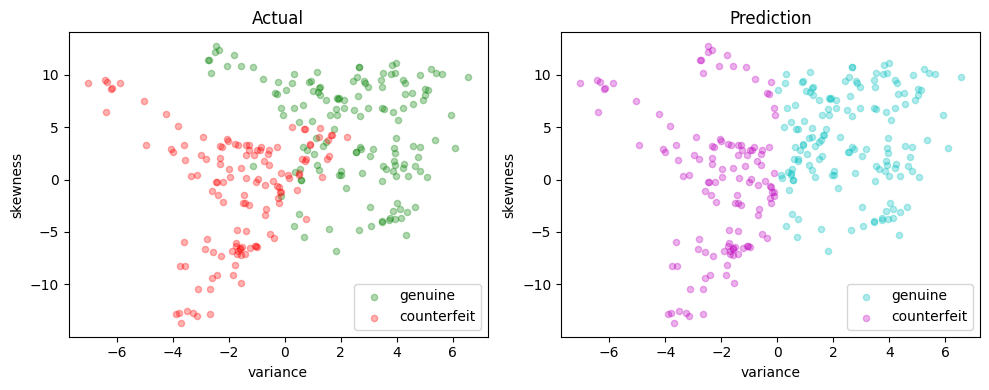

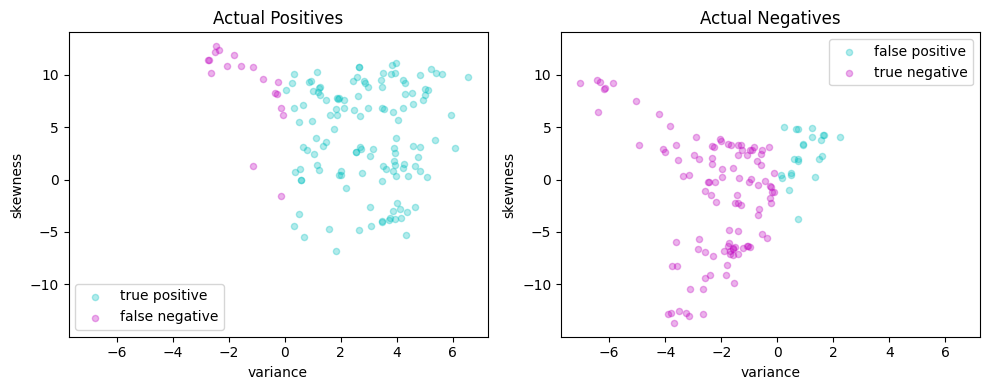

In [8]:
def scatter4(X: pd.DataFrame, y: pd.Series, y_pred: pd.Series):
    """
    Plots the actual versus predicted values of a binary classification model, as well as
    a breakdown of the performance by quadrant.

    Parameters
    ----------
    X : pandas.DataFrame
        A matrix with the features used to train the model.
    y : pandas.Series
        A vector with the actual binary labels of each observation in X.
    y_pred : pandas.Series
        A vector with the predicted binary labels of each observation in X.

    Returns
    -------
    None
    """

    xmin, ymin = X.min()
    xmax, ymax = X.max()
    xlim = [xmin - 0.05 * (xmax - xmin), xmax + 0.05 * (xmax - xmin)]
    ylim = [ymin - 0.05 * (ymax - ymin), ymax + 0.05 * (ymax - ymin)]

    # plot training and test sets
    labels = ["genuine", "counterfeit"]
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    scatter(
        X, y, labels, ["g", "r"], ax=ax[0], xlim=xlim, ylim=ylim, title="Actual"
    )
    scatter(
        X,
        y_pred,
        labels,
        ["c", "m"],
        ax=ax[1],
        xlim=xlim,
        ylim=ylim,
        title="Prediction",
    )
    fig.tight_layout()

    # plot training and test sets
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    scatter(
        X[y > 0],
        y_pred[y > 0],
        ["true positive", "false negative"],
        ["c", "m"],
        xlim=xlim,
        ylim=ylim,
        ax=ax[0],
        title="Actual Positives",
    )
    scatter(
        X[y < 0],
        y_pred[y < 0],
        ["false positive", "true negative"],
        ["c", "m"],
        xlim=xlim,
        ylim=ylim,
        ax=ax[1],
        title="Actual Negatives",
    )
    fig.tight_layout()


scatter4(X_test, y_test, y_pred)

As visible, there are still quite many points that could be classified correctly, and the number of false negatives and false positives is similar.

### Performance metrics

The accuracy score alone is not always a reliable metric for evaluating the performance of binary classifiers. For instance, when one outcome is significantly more frequent than the other, a classifier that always predicts the more common outcome without regard to the feature vector can achieve a very high accuracy score while being completely wrong on the less common outcome. 

Moreover, in many applications, the consequences of a false positive can differ from those of a false negative. For these reasons, we seek a more comprehensive set of metrics to compare binary classifiers. 
- Sensitivity of a classifier measures how many of the actually positive items in the dataset have been labelled as positive. 
- Precision, on the other hand, counts how many of the items marked as positive, are actually positive. 

A [detailed discussion on this topic](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7) recommends the [Matthews correlation coefficient (MCC)](https://towardsdatascience.com/the-best-classification-metric-youve-never-heard-of-the-matthews-correlation-coefficient-3bf50a2f3e9a) as a reliable performance measure for binary classifiers.

The code below demonstrates an example of a function that evaluates the performance of a binary classifier and returns the Matthews correlation coefficient as its output.

In [9]:
def validate(
    y_true: pd.Series, y_pred: pd.Series, verbose: bool = True
) -> float:
    """
    This function calculates and displays the sensitivity, precision, and Matthews correlation coefficient
    (MCC) for a binary classifier based on its true labels (y_true) and predicted labels (y_pred).

    Args:
    y_true (array-like): A list or array containing the true labels of the samples.
    y_pred (array-like): A list or array containing the predicted labels of the samples.
    verbose (bool, optional): If True, the function prints and displays the calculated metrics and
                              confusion matrix. Defaults to True.

    Returns:
    float: The calculated Matthews correlation coefficient (MCC).
    """

    # Calculate the elements of the confusion matrix
    true_positives = sum((y_true > 0) & (y_pred > 0))
    false_negatives = sum((y_true > 0) & (y_pred < 0))
    false_positives = sum((y_true < 0) & (y_pred > 0))
    true_negatives = sum((y_true < 0) & (y_pred < 0))
    total = true_positives + true_negatives + false_positives + false_negatives

    # Calculate the Matthews correlation coefficient (MCC)
    mcc_numerator = (true_positives * true_negatives) - (
        false_positives * false_negatives
    )
    mcc_denominator = np.sqrt(
        (true_positives + false_positives)
        * (true_positives + false_negatives)
        * (true_negatives + false_positives)
        * (true_negatives + false_negatives)
    )
    mcc = mcc_numerator / mcc_denominator

    if verbose:
        print(f"Matthews correlation coefficient (MCC) = {mcc:0.3f}")

        # report sensitivity and precision, and accuracy
        sensitivity = true_positives / (true_positives + false_negatives)
        precision = true_positives / (true_positives + false_positives)
        accuracy = (true_positives + true_negatives) / total

        print(f"Sensitivity = {100 * sensitivity: 0.1f}%")
        print(f"Precision = {100 * precision: 0.1f}%")
        print(f"Accuracy = {100 * accuracy: 0.1f}%")

        # Display the binary confusion matrix
        confusion_matrix = pd.DataFrame(
            [
                [true_positives, false_negatives],
                [false_positives, true_negatives],
            ],
            index=["Actual Positive", "Actual Negative"],
            columns=["Predicted Positive", "Predicted Negative"],
        )
        display(confusion_matrix)

    return mcc

We now apply this function to our original tool.

LinearSvm({'variance': 1, 'skewness': 0}, 0.0) 

Matthews correlation coefficient (MCC) = 0.701
Sensitivity =  87.6%
Precision =  84.7%
Accuracy =  85.1%


,Predicted Positive,Predicted Negative
Actual Positive,127,18
Actual Negative,23,107


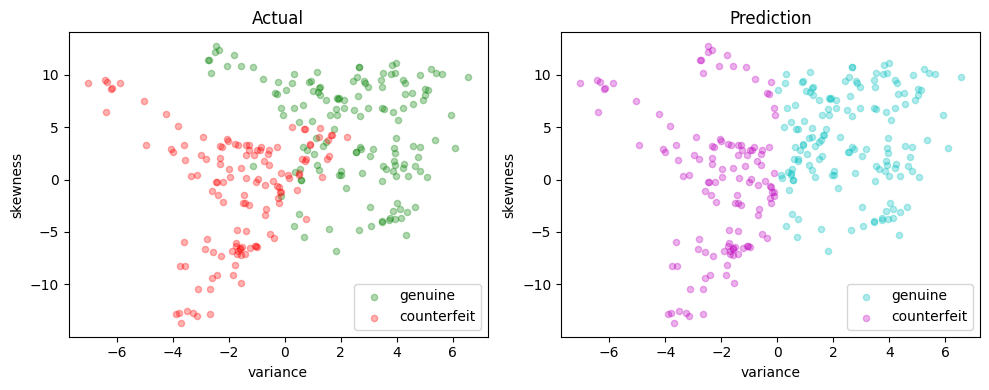

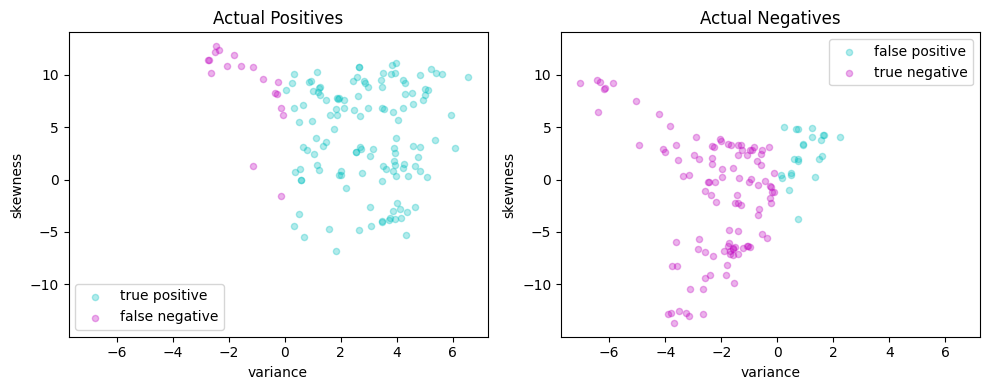

In [10]:
def test(svm, X_test, y_test):
    y_pred = svm(X_test)
    print(svm, "\n")
    validate(y_test, y_pred)
    scatter4(X_test, y_test, y_pred)


# train and test
svm = LinearSvm({"variance": 1, "skewness": 0}, 0.0)
test(svm, X_test, y_test)

## A LP model to find the best linear SVM classifier

Our goal now is to show how training a best-possible linear classifier can be posed and solved as a linear optimization problem. A training or validation set consists of $n$ observations $(x_i, y_i)$ where $y_i = \pm 1$ and $x_i\in\mathbb{R}^p$ for $i=1, \dots, n$. The training task is to find coefficients $w\in\mathbb{R}^p$ and $b\in\mathbb{R}$ to achieve high sensitivity and high precision for the validation set. 

Ideally, we would like to find $w$ and $b$ such that

$$
\begin{align*}
    w^\top x_i + b & > 0 & \forall i: y_i = +1 \\
    w^\top x_i + b & < 0 & \forall i: y_i = -1,
\end{align*}
$$

which can be wrapped into a single expression as:

$$
\begin{align*}
    y_i (w^\top x_i + b) & > 0 & \forall i = 1, 2, \dots, n.
\end{align*}
$$

This condition imposes no scale for $w$ or $b$ (i.e., if the condition is satisfied for any pair $(w, b)$ then it is also satisfied for $(\gamma w, \gamma b)$ where $\gamma > 0$). It is convenient, therefore, to impose a modified condition for correctly classified points where we secure a 'minimum margin 1 of the inequality to hold' so that, in a way, there is a strict separation between the positive and negative data points:

$$
\begin{align*}
y_i (w^\top x_i + b) & \geq 1 & \forall i = 1, 2, \dots, n
\end{align*}
$$

This condition is known as a **hard-margin** classifier. The size of the margin (how far each of the $+1$ and $-1$ subsets are from the line that separates them) is determined by the scale of $w$ and $b$. In practice, it is not always possible to find $w$ and $b$ that separate all the of data perfectly. 

For this purpose, when fitting an SVM to data it is common to use a **soft-margin** classifier obtained by minimizing the so-called **hinge-loss** function, which is equal to the difference between the right- and left-hand sides in the above equation if the inequality cannot be satisfied, and 0 if it works. Given parameters $w$ and $b$, the **hinge-loss** function is defined as

$$
\ell(x, y) = \left(1 - y(w^\top x + b)\right)^+,
$$

with the notation $z^+ = \max(0, z)$. The hinge-loss function is greater than 0 for any misclassified point and grows in proportion to how far away the feature vector is from the separation plane. 

With the hinge-loss, the training problem is formulated as minimizing the hinge-loss function over all the data samples:

$$
\begin{align*}
    \min_{w, b} \frac{1}{n}\sum_{i=1}^n \left(1 - y_i(w^\top x_i + b)\right)^+ .
\end{align*}
$$

Practice has shown that minimizing this term alone produces classifiers with large entries for $w$ which performs poorly on new data samples. For that reason, **regularization** adds a term to penalize the magnitude of $w$. In most formulations some norm $\|w\|$ is used for regularization, commonly a sum of squares such as $\|w\|_2^2 = \sum_i w_i^2$. Another choice is $\|w\|_1 = \sum_i |w_i|$ which, similar to Lasso regression, may result in sparse (consisting of lots of 0's) weighting vector $w$ indicating which elements of the feature vector can be neglected for classification purposes. 

Choosing for the latter function results in the objective function

$$
    \min_{w, b}\left[ \lambda \|w\|_1 + \frac{1}{n}\sum_{i=1}^n \left(1 - y_i(w^\top x_i + b)\right)^+ \right]
$$

By introducing $n$ auxiliary non-negative variables $z_i \geq 0$ such that

$$
\begin{align*}
y_i (w^\top x_i + b) & \geq 1 - z_i & \forall i = 1, 2, \dots, n
\end{align*}
$$

we can formulate the problem of fitting a linear classifier as:

$$
\begin{align*}
\min\quad  & \lambda \|w\|_1 + \frac{1}{n} \sum_{i=1}^n z_i \\
\text{s.t.} \quad &  z_i \geq 1 - y_i(w^\top x_i + b) & \forall i = 1, \dots, n \\
& z_i\geq 0 & \forall i = 1, \dots, n \\
& w\in\mathbb{R}^p \\
& b\in\mathbb{R}.
\end{align*}
$$

This is the primal optimization problem in decision variables $w\in\mathbb{R}^p$, $b\in\mathbb{R}$, and $z\in\mathbb{R}^n$, a total of $n + p + 1$ unknowns with $2n$ constraints. This can be recast as a linear optimization problem with the usual technique of setting $w = w^+ - w^-$ where $w^+$ and $w^-$ are non-negative. Then

$$
\begin{align*}
\min\quad  &\lambda \sum_{j=1}^p (w^+_j + w^-_j) + \frac{1}{n}  \sum_{i=1}^n z_i \\
\text{s.t.} \quad &  z_i \geq 1 - y_i((w^+ - w^-)^\top x_i + b) & \forall i = 1, \dots, n \\
& z_i \geq 0 & \forall i = 1, \dots, n \\
& w^+_j, w^-_j \geq 0 & \forall j = 1, \dots, p \\
& b\in\mathbb{R}.
\end{align*}
$$

### Pyomo implementation

We are now going to implement the optimization model for a linear SVM using Pyomo's `ConcreteModel`. An instance of the optimization model is created with a training set. This implementation is formulated as a function SVM *Factory* that produces instances of SVM objects from training data and other specifications, and which returns the SVM object as we formulated it above.

Immediately, we report also on the corresponding accuracy measures.

LinearSvm({'variance': 0.24531274, 'skewness': 0.052354873}, 0.026375191) 

Matthews correlation coefficient (MCC) = 0.750
Sensitivity =  94.5%
Precision =  83.5%
Accuracy =  87.3%


,Predicted Positive,Predicted Negative
Actual Positive,137,8
Actual Negative,27,103


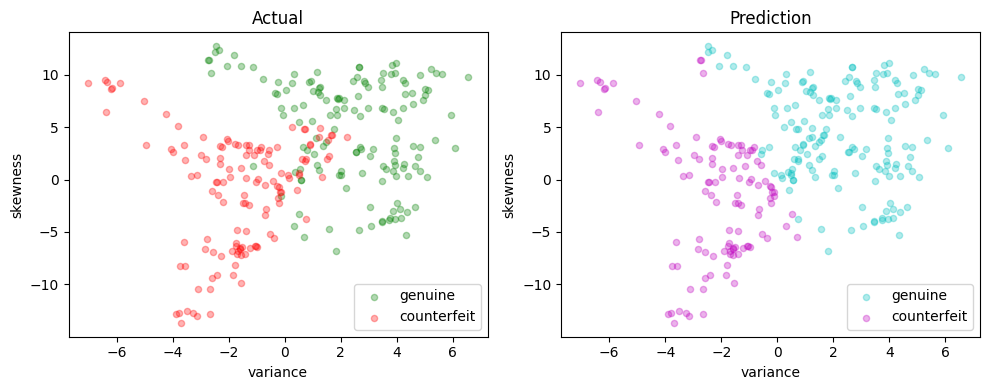

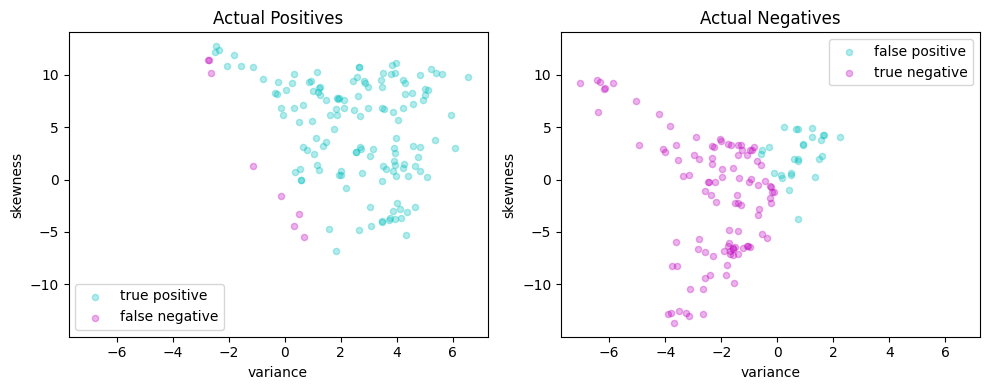

In [11]:
def svmFactory_LP(X: pd.DataFrame, y: pd.Series, lambd: float = 1) -> LinearSvm:
    """
    Creates a linear support vector machine classifier using a linear programming
    formulation with lasso regularization.

    Parameters
    ----------
    X : pandas.DataFrame
        The training data matrix.
    y : pandas.Series
        The training labels.
    lambd : float, optional
        The regularization strength, by default 1.

    Returns
    -------
    LinearSvm
        The trained linear support vector machine classifier.
    """

    m = pyo.ConcreteModel("Linear SVM")

    # use dataframe columns and index to index vars and constraints
    m.P = pyo.Set(initialize=X.columns)
    m.N = pyo.Set(initialize=X.index)

    # decision variables
    m.wp = pyo.Var(m.P, domain=pyo.NonNegativeReals)
    m.wn = pyo.Var(m.P, domain=pyo.NonNegativeReals)
    m.b = pyo.Var()
    m.z = pyo.Var(m.N, domain=pyo.NonNegativeReals)

    @m.Expression(m.P)
    def w(m, p):
        return m.wp[p] - m.wn[p]

    @m.Objective(sense=pyo.minimize)
    def lasso(m):
        return sum(m.z[i] for i in m.N) / len(m.N) + lambd * sum(
            m.wp[p] + m.wn[p] for p in m.P
        )

    @m.Constraint(m.N)
    def hingeloss(m, i):
        return m.z[i] >= 1 - y[i] * (
            sum(m.w[p] * X.loc[i, p] for p in m.P) + m.b
        )

    pyo.SolverFactory("cbc").solve(m)

    w = pd.Series([m.w[p]() for p in m.P], index=m.P)
    b = m.b()

    return LinearSvm(w, b)


# train and test
svm_lp = svmFactory_LP(X_train, y_train)
test(svm_lp, X_test, y_test)

As visible, the accuracy obtained with the optimally-tuned linear classifier is higher than that of the naive classified we created in the beginning. In the pictures, we can see that this is because the 'separating hyperplane' takes a skewed shape going from the top-left to the bottom right of our feature space.

Although we managed to improve the classifier accuracy significantly with respect to the naive classifier, there are even larger gains possible by going beyond a linear classifier and allowing more sophisticated models.

## Linear SVM with $L_2$ regularization term

We will now proceed with training nonlinear classifiers which can achieve higher accuracy than nonlinear ones. For computational reasons (as we shall see in the 'kernel trick') it is customary to fit nonlinear classifiers by solving the dual of the tuning/fitting problem. Because it is customary to derive this dual from a problem with a **quadratic regularizer** $\| \cdot \|_2$ instead of a $\| \cdot \|_1$ one, we begin with formulating the problem with a quadratic regularizer for a linear classifier.

### Primal form

The training objective is to minimize the total distance to misclassified data points, with a regularization function $ \| w \|_2^2$. The resulting optimization problem is a quadratic program with linear constraints, namely:

$$
\begin{align*}
\min\quad  & \frac{1}{2} \|w \|_2^2 + \frac{c}{n} \sum_{i=1}^n z_i \\
\text{s.t.} \quad &  z_i \geq 1 - y_i(w^\top x_i + b) & \forall i = 1, \dots, n \\
& z_i\geq 0 & \forall i = 1, \dots, n \\
& w\in\mathbb{R}^p \\
& b\in\mathbb{R}.
\end{align*}
$$

Choosing larger values of $c$ will reduce the number and size of misclassifications. The trade-off will be larger weights $w$ and the accompanying risk of overfitting the training data. 

The following cell formulates this optimization problem returning the resulting SVM as output and solves it using the general nonlinear optimization solver IPOPT.

LinearSvm({'variance': 0.36195702172185035, 'skewness': 0.11649516829892578}, -0.08254523955688992) 

Matthews correlation coefficient (MCC) = 0.792
Sensitivity =  95.2%
Precision =  86.2%
Accuracy =  89.5%


,Predicted Positive,Predicted Negative
Actual Positive,138,7
Actual Negative,22,108


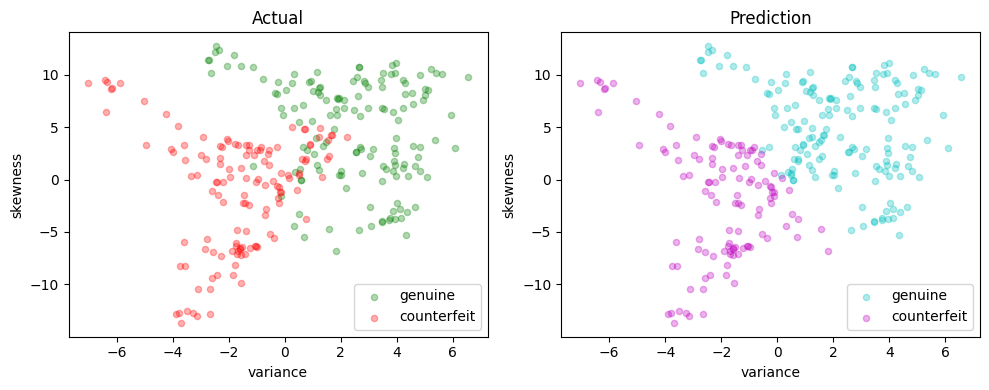

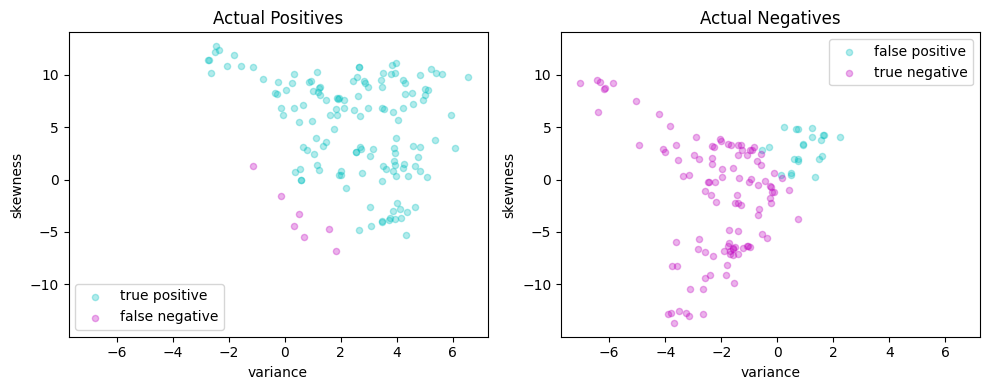

In [12]:
def svmFactory_QP(X: pd.DataFrame, y: pd.Series, c: float = 1) -> LinearSvm:
    """
    Train a linear SVM with quadratic programming.

    Parameters
    ----------
    X : pd.DataFrame
        Input data matrix of shape (n_samples, n_features).
    y : pd.Series
        Target values of shape (n_samples,).
    c : float, optional
        Regularization parameter, by default 1.

    Returns
    -------
    LinearSvm
        The trained linear SVM model.
    """

    m = pyo.ConcreteModel("Linear SVM with L2 regularization")

    # use dataframe columns and index to index vars and constraints
    m.P = pyo.Set(initialize=X.columns)
    m.N = pyo.Set(initialize=X.index)

    # decision variables
    m.w = pyo.Var(m.P)
    m.b = pyo.Var()
    m.z = pyo.Var(m.N, domain=pyo.NonNegativeReals)

    @m.Objective(sense=pyo.minimize)
    def qp(m):
        return sum(m.w[i] ** 2 for i in m.P) / 2 + (c / len(m.N)) * sum(
            m.z[i] for i in m.N
        )

    @m.Constraint(m.N)
    def hingeloss(m, i):
        return m.z[i] >= 1 - y[i] * (
            sum(m.w[p] * X.loc[i, p] for p in m.P) + m.b
        )

    pyo.SolverFactory("ipopt").solve(m)

    w = pd.Series([m.w[p]() for p in m.P], index=m.P)
    b = m.b()

    return LinearSvm(w, b)


# train and test
svm_qp = svmFactory_QP(X_train, y_train)
test(svm_qp, X_test, y_test)

The performance of the obtained linear classifier is very much similar to that of the previous one. However, for us this one was just a small step towards using nonlinear classifiers. We are now going to derive the dual of the above optimization problem.

### Dual Formulation

The dual formulation for the linear SVM above provides insight into how SVM works and it is essential for extending SVM to nonlinear classification. The dual formulation begins by creating a differentiable Lagrangian with dual variables $\alpha_i \geq 0$ and $\beta_i \geq 0$ for $i = 1, \dots, n$:

$$
\begin{align*}
\mathcal{L} & = \frac{1}{2} \|w\|_2^2 + \frac{c}{n}\sum_{i=1}^n z_i + \sum_{i=1}^n \alpha_i \left(1 - z_i - y_i (w^\top x_i + b) \right) + \sum_{i=1}^n \beta_i (-z_i)
\end{align*}
$$

To minimize this Lagrangian with respect to the original decision variables $w$, $b$, and $z$, we take the partial derivatives with respect to the primal variables and set them equal to zero, obtaining the following equations:

$$
\begin{align*}
\frac{\partial \mathcal{L}}{\partial z_i} & = \frac{c}{n} - \alpha_i - \beta_i = 0 \implies 0 \leq \alpha_i \leq \frac{c}{n}\\
\frac{\partial \mathcal{L}}{\partial w} & = w  - \sum_{i=1}^n \alpha_i y_i x_i = 0 \implies  w = \sum_{i=1}^n \alpha_i y_i x_i \\
\frac{\partial \mathcal{L}}{\partial b} & = - \sum_{i=1}^n \alpha_i y_i = 0 \implies \sum_{i=1}^n \alpha_i y_i = 0.
\end{align*}
$$

These can be arranged in the form of a standard quadratic optimization problem in $n$ variables $\alpha_i$ for $i = 1, \dots, n$.

$$
\begin{align*}
\min_{\alpha_i}\quad & \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_i y_j ( x_i^\top x_j ) -  \sum_{i=1}^n \alpha_i \\
\text{s.t.}\quad & \sum_{i=1}^n \alpha_i y_i = 0  \\
& \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n.
\end{align*}
$$

The resulting dual problem is thus also a quadratic optimization problem in $\alpha$ and it is easily checked that strong duality holds between the two problems because both the primal and the dual are easily (strictly) feasible. We can formulate the dual using a symmetric $n \times n$ **Gram matrix** defined as

$$
    G = \begin{bmatrix} 
        (y_1 x_1^\top)(y_1 x_1) & \dots & (y_1 x_1^\top)(y_n x_n) \\ 
        \vdots & \ddots & \vdots \\ 
        (y_n x_n^\top)(y_1 x_1) & \dots & (y_n x_n^\top)(y_n x_n)
    \end{bmatrix}
$$

With this matrix, the problem can be formulated as:

$$
\begin{align*}
\max \quad & \frac{1}{2} \alpha^\top G \alpha -  \sum_{i=1}^n \alpha_i \\
\text{s.t.}\quad & \sum_{i=1}^n \alpha_i y_i = 0  \\
& \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n.
\end{align*}
$$

Compared to the primal, the dual formulation appears to have reduced the number of decision variables from $n + p + 1$ to $n$. But this has come with the penalty of introducing a dense matrix with $n^2$ coefficients and potential processing time of order $n^3$. For large training sets where $n\sim 10^4-10^6$ or even larger, this becomes a prohibitively expensive calculation. In addition, the Gram matrix will be rank deficient for cases $p< n$. We can avoid computing and storing the full Gram matrix $G$ by introducing the $n \times p$ matrix $F$
 
$$
    F = \begin{bmatrix} y_1 x_1^\top \\ y_2 x_2^\top \\ \vdots \\ y_n x_n^\top \end{bmatrix},
$$

so that $G = FF^\top$. We can then recover the primal optimal solution from the dual optimal solution through the relationship $w = F^\top\alpha$. The optimization problem becomes

$$
\begin{align*}
\max \quad & \frac{1}{2} w^\top w -  1^\top\alpha \\
\text{s.t.}\quad & y^\top\alpha = 0 \\
& w = F^\top\alpha \\
& w\in\mathbb{R}^p \\
& 0 \leq \alpha \leq \frac{c}{n}\\
& \alpha\in\mathbb{R}^n
\end{align*}
$$

With respect to the other part of the primal solution (the SVM consists of two parts: $w$ and $b$), we can recover the bias term $b$ by considering the complementarity conditions on the dual variables. The slack variables $z_i$ are zero if $\beta_i > 0$ which is equivalent to $\alpha_i < \frac{c}{n}$. If $\alpha_i > 0$ then $1 - y_i (w^\top x_i + b)$. Putting these facts together gives a formula for $b$

$$
\begin{align}
b & = y_i - w^\top x_i & \forall i\in 1, 2, \ldots, n\quad \text{s.t.}\quad 0 < \alpha_i < \frac{c}{n}.
\end{align}
$$

The set of non-zero coefficients $\alpha_i > 0$ defines the so-called set of support vectors $\mathcal{SV}$. This model is implemented below.

Visualization of the support vectors (correspondings to alpha_i>0)


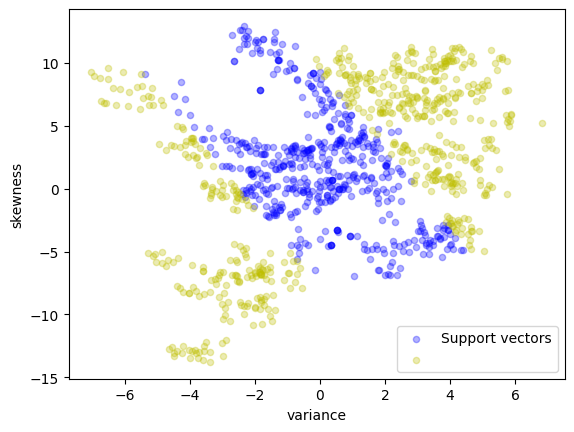

LinearSvm({'variance': 0.36195647889145716, 'skewness': 0.11649581980710291}, -0.08254328998157412) 

Matthews correlation coefficient (MCC) = 0.792
Sensitivity =  95.2%
Precision =  86.2%
Accuracy =  89.5%


,Predicted Positive,Predicted Negative
Actual Positive,138,7
Actual Negative,22,108


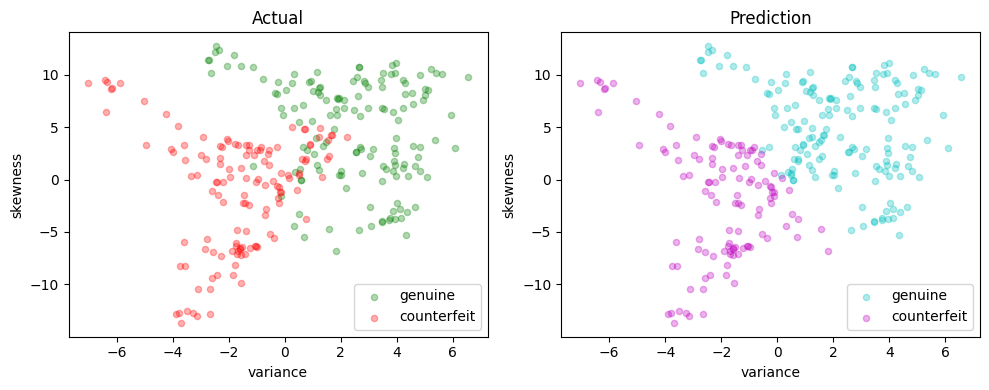

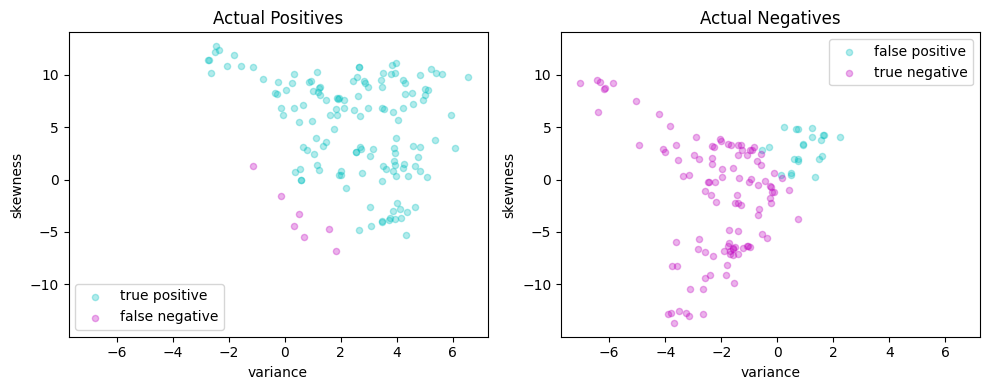

In [13]:
def svmFactory_dual(X: pd.DataFrame, y: pd.Series, c: float = 1.0) -> LinearSvm:
    """
    Train a linear SVM using its dual formuation

    Parameters
    ----------
    X : pd.DataFrame
        Input data matrix of shape (n_samples, n_features).
    y : pd.Series
        Target values of shape (n_samples,).
    c : float, optional
        Regularization parameter, by default 1.

    Returns
    -------
    LinearSvm
        The trained linear SVM model.
    """
    m = pyo.ConcreteModel("Linear SVM via dual formulation")

    # use dataframe columns and index to index vars and constraints
    m.P = pyo.Set(initialize=X.columns)
    m.N = pyo.Set(initialize=X.index)

    # model parameters
    F = X.mul(y, axis=0)
    C = c / len(m.N)

    # decision variables
    m.w = pyo.Var(m.P)
    m.a = pyo.Var(m.N, bounds=(0, C))

    @m.Objective(sense=pyo.minimize)
    def qp(m):
        return sum(m.w[i] ** 2 for i in m.P) / 2 - sum(m.a[i] for i in m.N)

    @m.Constraint()
    def bias(m):
        return sum(y.loc[i] * m.a[i] for i in m.N) == 0

    @m.Constraint(m.P)
    def projection(m, p):
        return m.w[p] == sum(F.loc[i, p] * m.a[i] for i in m.N)

    # solve QP with interior point method
    pyo.SolverFactory("ipopt").solve(m)

    # extract solution
    w = pd.Series([m.w[p]() for p in m.P], index=m.P)
    a = pd.Series([m.a[i]() for i in m.N], index=m.N)

    # visualize support vectors
    y_support = pd.Series(
        [1 if m.a[i]() > 1e-3 * C else -1 for i in m.N], index=X.index
    )
    print("Visualization of the support vectors (correspondings to alpha_i>0)")
    scatter(
        X,
        y_support,
        colors=["b", "y"],
        labels=["Support vectors", ""],
    )
    plt.show()

    # find alpha closest to the center of [0, c/n]
    i = a.index[(a - C / 2).abs().argmin()]
    b = y.loc[i] - X.loc[i, :].dot(w)

    return LinearSvm(w, b)


# train and test
svm_dual = svmFactory_dual(X_train, y_train)
test(svm_dual, X_test, y_test)

## Kernelized (nonlinear) SVM

We will now introduce the idea of kernelized (nonlinear) support vector machines. Although such SVMs are almost always solved by solving the dual problem (it has a much smaller dimensionality than the primal one, as the above argument has shown), we first present the derivation through the primal to give more of the intuition.

### Nonlinear feature spaces

A linear SVM assumes the existence of a linear hyperplane that separates labeled sets of data points. Frequently, however, this is not possible and some sort of nonlinear method where the feature vector is appended with nonlinear transformations 

$$
x \rightarrow \phi(x)
$$

where $\phi(x)$ is a function mapping $x$ into a higher dimensional feature space. That is, $\phi : \mathbb{R}^{p} \rightarrow \mathbb{R}^d$ where $d \geq p $. The additional dimensions may include features such as powers of the terms in $x$, products of those terms, or other types of nonlinear transformations. In this way, the SVM has more 'room to play' in order to try to separate one point from another. 

Corresponding to such a transformed vector, we have a binary classification tool given by

$$y^{pred} = \text{sgn} \left( w^\top \phi(x) + b \right).$$

As before, we wish to find a choice for $w\in\mathbb{R}^d$ such that the soft-margin classifier

$$
\begin{align}
y_i \left( w^\top \phi(x_i) + b \right) & \geq 1 - z_i  & i = 1, 2, \ldots, n
\end{align}
$$

Using the machinery as before, we set up the Lagrangian for the $\| \cdot \|_2^2$-regularized problem:

$$
\begin{align*}
\mathcal{L} & = \frac{1}{2} \|w\|_2^2 + \frac{c}{n}\sum_{i=1}^n z_i + \sum_{i=1}^n \alpha_i \left( 1 - z_i - y_i \left( w^\top \phi(x_i) + b \right)\right) + \sum_{i=1}^n \beta_i (-z_i) \\
\end{align*}
$$

then take derivatives to find

$$
\begin{align*}
    \frac{\partial \mathcal{L}}{\partial z_i} & = \frac{c}{n} - \alpha_i - \beta_i = 0 \implies 0 \leq \alpha_i \leq \frac{c}{n}\\
    \frac{\partial \mathcal{L}}{\partial w} & = w  - \sum_{i=1}^n \alpha_i y_i \phi(x_i) = 0 \implies  w = \sum_{i=1}^n \alpha_i y_i \phi(x_i) \\
\frac{\partial \mathcal{L}}{\partial b} & = - \frac{c}{n}\sum_{i=1}^n \alpha_i y_i = 0 \implies \sum_{i=1}^n \alpha_i y_i = 0
\end{align*}
$$

This is similar to the case of a linear SVM, but now the vector of weights $w\in\mathbb{R}^d$ which can be a  high dimensional space with nonlinear features. Working through the algebra, we are once again left with a quadratic program in $n$ variables $\alpha_i$ for $i = 1, \dots, n$.

$$
\begin{align*}
\max \quad & \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_i y_j  \phi(x_i)^\top \phi(x_j) -  \sum_{i=1}^n \alpha_i \\
\text{s.t.}\quad  & \sum_{i=1}^n \alpha_i y_i = 0 \\
& \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n
\end{align*}
$$

where the resulting classifier for a new point $x$ is given by 

$$y^{pred} = \text{sgn} \left( w^\top \phi(x) + b \right) = \text{sgn} \left( \sum_{i=1}^n \alpha_i y_i \phi(x_i)^\top \phi(x) + b \right).$$

### The kernel trick

If you look at the optimization problem above and the corresponding classifier tool, this is an interesting situation where the separating hyperplane is embedded in a high dimensional space of nonlinear features determined by the mapping $\phi(x)$, but all we need to train the classifier and to use the classifier are the inner products  $\phi(x_i)^\top\phi(x_j)$ and $\phi(x_i)^\top\phi(x)$, rather than the 'raw' $\phi(x_i)$ and $\phi(x)$ values. If we had a function $K(x, z)$ that returned the value $\phi(x)^\top\phi(z)$ then we would never need to actually compute $\phi(x)$, $\phi(z)$ or their inner product.

Mercer's theorem turns the analysis on its head by specifying conditions for which a function $K(x, z)$ can expressed as an inner product for some $\phi(x)$. If $K(x, z)$ is symmetric, i.e, $K(x, z) = K(z, x)$, and if the Gram matrix constructed for any collection of points $x_1, x_2, \ldots, x_n$ 

$$
\begin{bmatrix} 
    K(x_1, x_1) & \dots & K(x_1, x_n) \\ 
    \vdots & \ddots & \vdots \\ 
    K(x_n, x_1) & \dots & K(x_n, x_n) 
\end{bmatrix}
$$

is positive semi-definite, then there is some $\phi(x)$ for which $K(x, z)$ is an inner product. We call such functions kernels. The practical consequence is that we can train and implement nonlinear classifiers using kernels without ever needing to compute the higher dimensional features. This remarkable result is called the "kernel trick".

### Implementation

To take advantage of the kernel trick, we assume an appropriate kernel $K(x, z)$ has been identified, then replace all instances of $\phi(x_i)^\top \phi(x)$ with the kernel. The "kernelized" SVM is given by a solution to 

$$
\begin{align*}
\max \quad & \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_i y_j K(x_i, x_j) -  \sum_{i=1}^n \alpha_i \\
\text{s.t.}\quad & \sum_{i=1}^n \alpha_i y_i = 0 \\
& \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
\end{align*}
$$

where

$$
\begin{align}
b & = y_i - \sum_{j=1}^n \alpha_j y_j K(x_j, x_i) & \forall i\in 1, 2, \ldots, n\quad \text{s.t.}\quad 0 < \alpha_i < \frac{c}{n}.
\end{align}
$$

The resulting classifier is given by 

$$y^{pred} = \text{sgn} \left( \sum_{i=1}^n \alpha_i y_i K(x_i, x) + b \right).$$

For a more compact formulation, we can define the $n\times n$ positive symmetric semi-definite Gram matrix

$$
G = \begin{bmatrix} 
    y_1 y_1 K(x_1, x_1) & \dots & y_1 y_n K(x_1, x_n) \\ 
    \vdots & \ddots & \vdots \\ 
    y_n y_1 K(x_n, x_1) & \dots & y_n y_n K(x_n, x_n) 
\end{bmatrix}
$$

As already mentioned in the case of linear SVMs, the Gram matrix corresponding to the quadratic optimization dual problem can be not full-rank which can lead to some numerical issues. To address this issue, we can  factor $G = F F^\top$ where $F$ has dimensions $n \times q$ and where $q$ is the rank of $G$. The factorization is not unique. As demonstrated in the Python code below, one suitable factorization is the spectral factorization $G = U\Lambda U^T$ where $\Lambda$ is a $q\times q$ diagonal matrix of non-zero eigenvalues, and $U$ is an $n\times q$ normal matrix such that $U^\top U = I_q$. Then

$$F = U\Lambda^{1/2}$$

Once this factorization is complete, the optimization problem for the kernelized SVM is the same as for the linear SVM in the dual formulation

$$
\begin{align*}
\max \quad & \frac{1}{2} \alpha^\top F F^\top \alpha -  1^\top \alpha \\
\text{s.t.} \quad & \sum_{i=1}^n \alpha_i y_i = 0 \\
& 0 \leq \alpha \leq \frac{c}{n}\\
& \alpha\in\mathbb{R}^n. \\
\end{align*}
$$

The result is a quadratic problem for the dual coefficients $\alpha$ and auxiliary variables $v$:

$$
\begin{align*}
\max \quad & \frac{1}{2} v^\top v - 1^\top \alpha\\
\text{s.t.} \quad & y^\top \alpha = 1 \\
& v = F^\top \alpha \\
& 0 \leq \alpha \leq \frac{c}{n} \\
& v\in\mathbb{R}^{q} \\
& \alpha\in\mathbb{R}^n.
\end{align*}
$$

To summarize, the essential difference between training the linear and kernelized SVM is the need to compute and factor the Gram matrix. The result is a set of non-zero coefficients $\alpha_i > 0$ that define a set of support vectors $\mathcal{SV}$. The classifier is then given by

$$y^{pred} = \text{sgn} \left( \sum_{i\in\mathcal{SV}} \alpha_i y_i K(x_i, x) + b \right)$$

The following cell implements this model, then tests the resulting classifier for the polynomial kernel of order 3 (which corresponds to including in the feature vector the powers of all features up to and including degree 3), solved using the IPOPT nonlinear solver.

In [14]:
import pyomo.kernel as pmo


def svmFactory_kernel(
    X: pd.DataFrame,
    y: pd.Series,
    c: float = 1,
    tol: float = 1e-8,
    kernel: callable = lambda x, z: (1 + x @ z) ** 3,
):
    """
    Constructs a kernelized support vector machine (SVM) model using Pyomo optimization package.

    Parameters:
    ----------
    X : pandas.DataFrame
        The training dataset input features.
    y : pandas.Series
        The training dataset labels.
    c : float, optional (default=1)
        The cost parameter for the SVM optimization problem.
    tol : float, optional (default=1e-8)
        Tolerance value for singular value decomposition (SVD) in the optimization problem.
    kernel : callable, optional (default=lambda x, z: (1 + x @ z) ** 3)
        The kernel function for the SVM.

    Returns:
    -------
    callable
        A callable function that returns the predicted class labels for new data points.

    """

    n, p = X.shape

    # convert to numpy arrays for speed
    X_ = X.to_numpy()
    y_ = y.to_numpy()

    # kernel matrix
    G = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            G[j, i] = G[i, j] = y_[i] * y_[j] * kernel(X_[i, :], X_[j, :])

    # spectral factors
    eigvals, V = np.linalg.eigh(G)
    idx = eigvals >= tol * max(eigvals)
    F = pd.DataFrame(V[:, idx] @ np.diag(np.sqrt(eigvals[idx])), index=X.index)

    # build model
    m = pyo.ConcreteModel()

    # use dataframe columns and index to index vars and constraints
    m.Q = pyo.Set(initialize=F.columns)
    m.N = pyo.Set(initialize=F.index)

    # model parameters
    C = c / len(m.N)

    # decision variables
    m.u = pyo.Var(m.Q)
    m.a = pyo.Var(m.N, bounds=(0, C))

    @m.Objective(sense=pyo.minimize)
    def qp(m):
        return sum(m.u[i] ** 2 for i in m.Q) / 2 - sum(m.a[i] for i in m.N)

    @m.Constraint()
    def bias(m):
        return sum(y.loc[i] * m.a[i] for i in m.N) == 0

    @m.Constraint(m.Q)
    def projection(m, q):
        return m.u[q] == sum(F.loc[i, q] * m.a[i] for i in m.N)

    # solve QP with interior point method
    pyo.SolverFactory("ipopt").solve(m)

    # extract solution
    a = pd.Series([m.a[i]() for i in m.N], index=m.N)

    # visualize support vectors
    y_support = pd.Series(
        [1 if m.a[i]() > 1e-3 * C else -1 for i in m.N], index=X.index
    )
    print("Visualization of the support vectors (correspondings to alpha_i>0)")
    scatter(
        X,
        y_support,
        colors=["b", "y"],
        labels=["Support vectors", ""],
    )
    plt.show()

    # define the support vectors
    SV = [i for i in m.N if m.a[i]() > 1e-3 * C]

    # find alpha closest to the center of [0, c/n]
    i = a.index[(a - C / 2).abs().argmin()]

    b = y.loc[i] - sum(
        [a[j] * y.loc[j] * kernel(X.loc[j, :], X.loc[i, :]) for j in m.N]
    )

    def kernelSVM(Z):
        y_pred = pd.Series(
            [
                np.sign(
                    sum(
                        a[i] * y[i] * kernel(X.loc[i, :], Z.loc[j, :])
                        for i in SV
                    )
                    + b
                )
                for j in Z.index
            ],
            index=Z.index,
        )
        return y_pred

    return kernelSVM

The next cell defines computes the accuracy of the resulting SVM.

Visualization of the support vectors (correspondings to alpha_i>0)


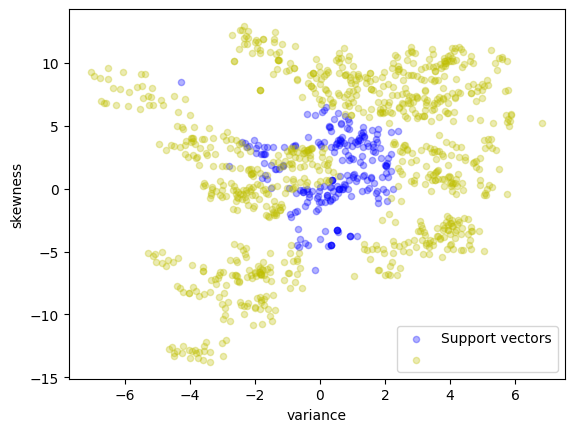

<function svmFactory_kernel.<locals>.kernelSVM at 0x1761abc70> 

Matthews correlation coefficient (MCC) = 0.833
Sensitivity =  91.0%
Precision =  93.0%
Accuracy =  91.6%


,Predicted Positive,Predicted Negative
Actual Positive,132,13
Actual Negative,10,120


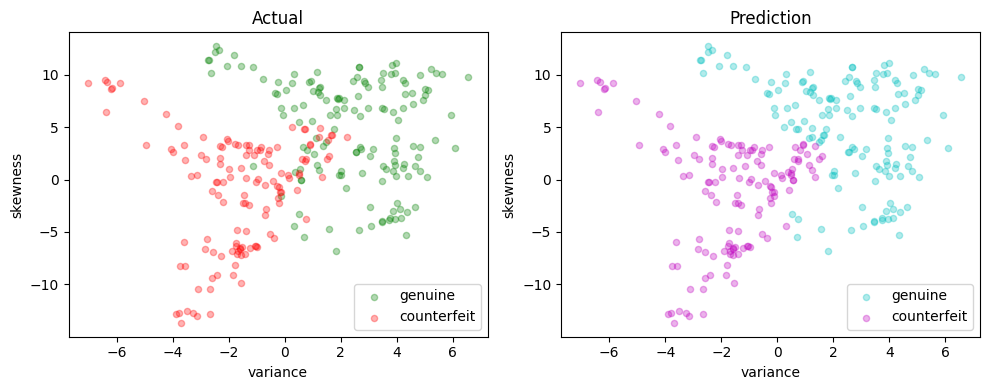

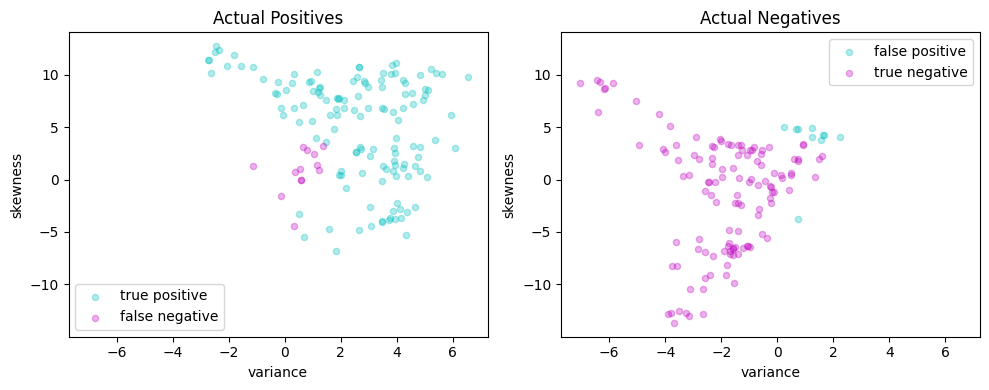

In [15]:
svm_kernel = svmFactory_kernel(X_train, y_train)
test(svm_kernel, X_test, y_test)

As visible, the ability to use a nonlinear transformation of the features allows us to gain an extra 0.1 in the value of the Matthews correlation coefficient. 

You can try yourself with other kernel functions how the corresponding value of the coefficient could evolve, playing also with the value of the regularization coefficient $c$ to find the best one.